# Value Prediction

This notebook explores the [Olist Brazilian e-commerce](https://www.kaggle.com/olistbr/brazilian-ecommerce) and [marketing](https://www.kaggle.com/olistbr/marketing-funnel-olist) Kaggle datasets from a Value Prediction perspective. By analyzing revenue using exploratory data analysis (EDA), feature engineering, regression models, and time-series forecasting, we gain valuable insight into the key sources of revenue for the business, as well as how to predict future sales and what features have the biggest impact. 

### Table of Contents
1. [Data Importing, Cleaning, and Filtering](#dataimporting)
2. [EDA - revenue](#EDAseller)
3. [EDA - seller](#EDArevenue)
4. [EDA - monthly revenue by seller](#EDAmonthlyrevenue)
5. [EDA - top seller](#EDAtopseller)
6. [Feature Engineering - convert categoricals](#convertingcategoricals)
7. [Feature Selection](#featureselection)
8. [Linear Regression](#linreg)
9. [Time-series Prediction](#timeseries)
10. [Time-series Prediction - Neural Net](#neuralnet)
11. [Time-series Prediction - FB prophet](#prophet)

<a name="dataimporting"></a>

## Data Importing, Cleaning, and Filtering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import sqrt

from sklearn import feature_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, GRU

from fbprophet import Prophet 

In [2]:
closed = pd.read_csv('data/olist_closed_deals_dataset.csv')

In [3]:
leads = pd.read_csv('data/olist_marketing_qualified_leads_dataset.csv', parse_dates=['first_contact_date'])

In [4]:
sellers = pd.read_csv('data/olist_sellers_dataset.csv')

In [5]:
items = pd.read_csv('data/olist_order_items_dataset.csv')

In [6]:
orders = pd.read_csv('data/olist_orders_dataset.csv',parse_dates=['order_purchase_timestamp'])

In [7]:
products = pd.read_csv('data/olist_products_dataset.csv')

In [8]:
product_translation = pd.read_csv('data/product_category_name_translation.csv')

In [9]:
marketing = pd.merge(closed,leads,on='mql_id')

In [10]:
data = marketing.merge(items, on='seller_id', how='left')

data = pd.merge(data, orders, how='inner', on='order_id')

data = pd.merge(data, products,how='inner', on='product_id')

data = pd.merge(data, product_translation,how='left', on='product_category_name')

data = pd.merge(data, sellers, how='inner',on='seller_id')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5044 entries, 0 to 5043
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         5044 non-null   object        
 1   seller_id                      5044 non-null   object        
 2   sdr_id                         5044 non-null   object        
 3   sr_id                          5044 non-null   object        
 4   won_date                       5044 non-null   object        
 5   business_segment               5044 non-null   object        
 6   lead_type                      4996 non-null   object        
 7   lead_behaviour_profile         3303 non-null   object        
 8   has_company                    30 non-null     object        
 9   has_gtin                       30 non-null     object        
 10  average_stock                  30 non-null     object        
 11  business_type    

In [14]:
# rename target variable

data = data.rename(columns={'price':'revenue'})

In [15]:
# datetime conversions

data["contact_month"] = pd.to_datetime(data['first_contact_date']).dt.month 
data['won_date']= pd.to_datetime(data['won_date']) 
data["closing_days"] = (data['won_date'] - data['first_contact_date']).dt.days

In [16]:
# drop heuristically irrelevant columns and columns with mostly nulls 

data = data.drop(columns=['mql_id', 'sdr_id', 'sr_id',
       'declared_product_catalog_size','declared_monthly_revenue','order_id',
       'order_item_id', 'product_id', 'shipping_limit_date',
       'freight_value', 'customer_id', 'order_status',
       'order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
        'declared_product_catalog_size','has_company','average_stock','has_gtin',
        'seller_zip_code_prefix','seller_state'])

In [17]:
data.dtypes

seller_id                                object
won_date                         datetime64[ns]
business_segment                         object
lead_type                                object
lead_behaviour_profile                   object
business_type                            object
first_contact_date               datetime64[ns]
landing_page_id                          object
origin                                   object
revenue                                 float64
order_purchase_timestamp         datetime64[ns]
product_category_name_english            object
seller_city                              object
contact_month                             int64
closing_days                              int64
dtype: object

In [18]:
#nulls

data.isna().sum().sort_values(ascending=False)

lead_behaviour_profile           1741
product_category_name_english      50
lead_type                          48
origin                             11
business_type                       5
closing_days                        0
contact_month                       0
seller_city                         0
order_purchase_timestamp            0
revenue                             0
landing_page_id                     0
first_contact_date                  0
business_segment                    0
won_date                            0
seller_id                           0
dtype: int64

In [19]:
#only categorical nulls to fill 

data.fillna({'lead_behaviour_profile':'other','product_category_name_english':'other',
            'lead_type':'other','origin':'other','business_type':'other'},inplace=True)


In [20]:
data.isna().sum().sort_values(ascending=False)

closing_days                     0
contact_month                    0
seller_city                      0
product_category_name_english    0
order_purchase_timestamp         0
revenue                          0
origin                           0
landing_page_id                  0
first_contact_date               0
business_type                    0
lead_behaviour_profile           0
lead_type                        0
business_segment                 0
won_date                         0
seller_id                        0
dtype: int64

<a name="EDAseller"></a>

<a name="EDArevenue"></a>

## EDA - Revenue

In [21]:
data['order_purchase_timestamp(y-d)'] = data['order_purchase_timestamp'].dt.to_period('D')
#data[['order_purchase_timestamp', 'order_purchase_timestamp(y-d)']].head(1000)

In [22]:
timeseries = data.groupby(by='order_purchase_timestamp(y-d)')['revenue'].sum()
prophetdf = data.groupby(by='order_purchase_timestamp')['revenue'].sum()

timeseries.to_frame().T

order_purchase_timestamp(y-d),2018-01-24,2018-01-26,2018-01-31,2018-02-02,2018-02-04,2018-02-05,2018-02-06,2018-02-09,2018-02-13,2018-02-14,...,2018-08-20,2018-08-21,2018-08-22,2018-08-23,2018-08-24,2018-08-25,2018-08-26,2018-08-27,2018-08-28,2018-08-29
revenue,70.0,634.4,89.9,104.49,185.0,39.5,397.8,228.9,218.39,515.98,...,5040.79,4161.0,4031.09,3713.38,1525.73,1232.36,1576.8,689.56,393.89,592.55


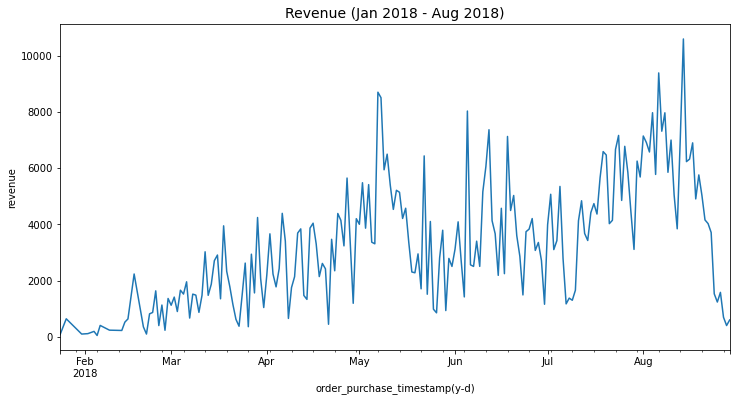

In [23]:
timeseries.plot.line(figsize=(12, 6))
plt.title('Revenue (Jan 2018 - Aug 2018)', fontsize=14)
plt.ylabel('revenue');

<a name="EDAseller"></a>

## EDA - sellers

In [24]:
sellerprice = pd.DataFrame(data.groupby(by='seller_id')['revenue'].sum().sort_values(ascending=False).reset_index())


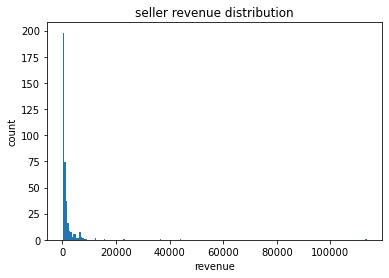

In [25]:
plt.hist(sellerprice.revenue, bins=200)
plt.xlabel('revenue')
plt.ylabel('count')
plt.title('seller revenue distribution');

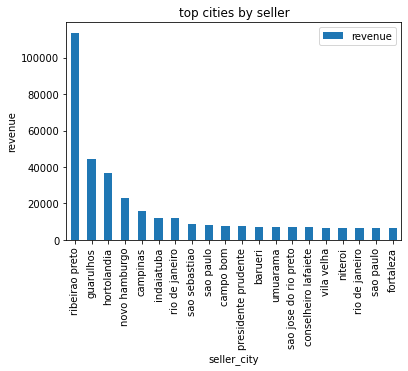

In [26]:
topcities = data.groupby(by=['seller_id','seller_city'])['revenue'].sum().sort_values(ascending=False).reset_index()
topcities = pd.DataFrame(topcities)
topcities = topcities[:20]
ax = topcities.plot.bar(x='seller_city', y='revenue')
plt.title('top cities by seller')
plt.ylabel('revenue');


<a name="EDAmonthlyrevenue"></a>

## EDA - Monthly Revenue by Seller

In [27]:
data['order_purchase_timestamp(y-m)'] = data['order_purchase_timestamp'].dt.to_period('M')

In [28]:
#group by seller id and calculate monthly revenue
cols = data.groupby(by='seller_id').revenue.sum().sort_values(ascending=False).index

#filter top 20
cols = cols[:20]

In [29]:
monthly_seller_revenue = data.groupby(['order_purchase_timestamp(y-m)', 'seller_id']).revenue.sum() \
                              .unstack(level=1, fill_value=0)

In [30]:
monthly_seller_revenue = monthly_seller_revenue[cols]

In [31]:
monthly_seller_revenue

seller_id,7d13fca15225358621be4086e1eb0964,ba90964cff9b9e0e6f32b23b82465f7b,c70c1b0d8ca86052f45a432a38b73958,612170e34b97004b3ba37eae81836b4c,6061155addc1e54b4cfb51c1c2a32ad8,c510bc1718f0f2961eaa42a23330681a,70c27847eca8195c983ed7e798c56743,db2956745b3a8e9f3785c99f34b5d25e,4bfc7a4a1cf8d4d2121c27422d9e50b5,8476243f92442881ddd5b578975cf115,8a432f4e5b471f8da497d7dc517666e2,0873d9f8f36123f8d910f4760e788cfb,ade45994b717ccee333492330fbf037b,cc63f0dd2acba93ffed4fe9f8e0321fa,58f1a6197ed863543e0136bdedb3fce2,33dd941c27854f7625b968cc6195a552,a63bfbaa882c8f4542891b4e2246cc7f,516e7738bd8f735ac19a010ee5450d8d,5670f4db5b62c43d542e1b2d56b0cf7c,dbdd0ec73a4817971d962698f2fea022
order_purchase_timestamp(y-m),,,,,,,,,,,,,,,,,,,,
2018-01,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0
2018-02,6064.35,140.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0
2018-03,27727.45,12620.0,0.00,0.00,0.0,0.00,0.00,0.0,188.7,2487.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0
2018-04,22240.90,12529.9,3709.27,0.00,0.0,7716.00,2739.56,872.0,536.6,1129.0,926.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,18.56,399.0
2018-05,31564.81,13547.6,9114.50,0.00,0.0,0.00,1191.23,2566.0,2046.9,928.0,2081.0,1520.88,0.0,1543.90,507.0,2755.0,0.0,1848.50,857.29,798.0
2018-06,9525.98,3198.0,9674.21,2275.59,918.9,3918.95,2525.31,1521.0,1032.9,0.0,981.0,1005.55,4329.0,550.95,824.0,2755.0,2288.0,3030.19,2135.59,1596.0
2018-07,6693.44,779.0,7738.50,15770.33,3511.0,119.90,2867.67,2059.0,3137.4,728.0,1203.0,2469.83,1710.0,1883.04,5128.0,0.0,3288.0,1225.10,1902.72,2394.0
2018-08,9812.04,1398.0,6300.89,5019.10,11203.5,496.15,2753.75,1581.0,1181.9,2566.0,2364.0,2269.33,1157.0,3118.82,374.0,1277.5,1196.0,539.30,1715.93,1197.0


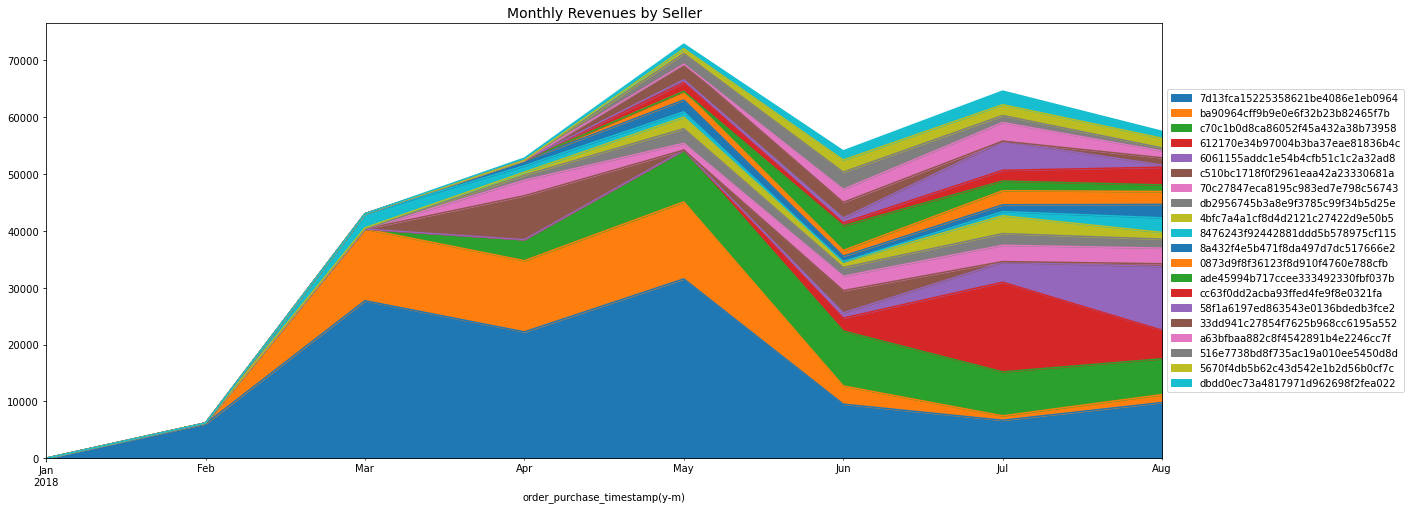

In [32]:
monthly_seller_revenue.plot.area(figsize=(20,8))

plt.title('Monthly Revenues by Seller', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

<a name="EDAtopseller"></a>

## EDA - Top Seller

In [33]:
top_seller = data[data.seller_id == '7d13fca15225358621be4086e1eb0964']

In [34]:
top = top_seller.revenue.sum()/data.revenue.sum()
print(f'The top seller % of total sales on Olist is {top}')

The top seller % of total sales on Olist is 0.1678787346376195


In [35]:
cols = top_seller.groupby('product_category_name_english').revenue.sum().sort_values(ascending=False).index

monthly_revenue_category = top_seller.groupby(['order_purchase_timestamp(y-m)', 'product_category_name_english']) \
                                  .revenue \
                                  .sum() \
                                  .unstack(level=1, fill_value=0)

monthly_revenue_category = monthly_revenue_category[cols]

print('Product Categories for Top Seller')

monthly_revenue_category

Product Categories for Top Seller


product_category_name_english,watches_gifts,audio,electronics,sports_leisure,cool_stuff,market_place,perfumery
order_purchase_timestamp(y-m),,,,,,,
2018-02,5194.25,590.00,280.10,0.0,0.0,0.0,0.0
2018-03,19394.69,7547.76,240.00,545.0,0.0,0.0,0.0
2018-04,15911.04,5609.89,719.97,0.0,0.0,0.0,0.0
2018-05,29348.81,2216.00,0.00,0.0,0.0,0.0,0.0
2018-06,7705.98,1172.00,0.00,468.0,180.0,0.0,0.0
2018-07,5047.44,876.00,370.00,0.0,180.0,0.0,220.0
2018-08,7509.86,550.00,1464.58,0.0,0.0,287.6,0.0


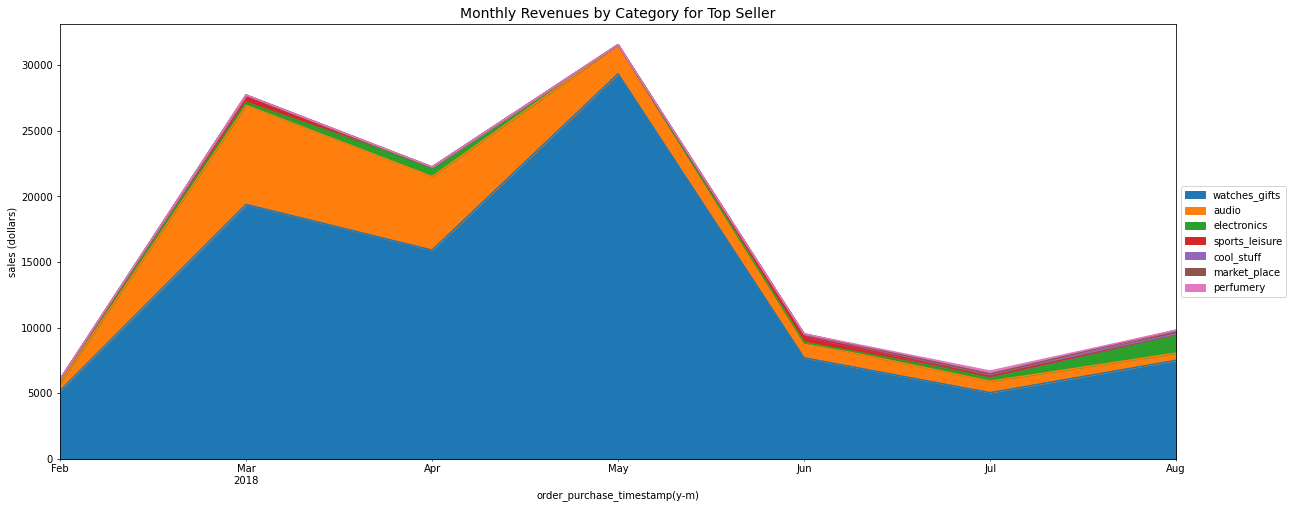

In [36]:
monthly_revenue_category.plot.area(figsize=(20,8))

plt.title('Monthly Revenues by Category for Top Seller', fontsize=14)
plt.ylabel('sales (dollars)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

In [37]:
print('the top category percentages')
top_seller.groupby('product_category_name_english').revenue.sum()/top_seller.revenue.sum()

the top category percentages


product_category_name_english
audio             0.163353
cool_stuff        0.003168
electronics       0.027059
market_place      0.002531
perfumery         0.001936
sports_leisure    0.008915
watches_gifts     0.793038
Name: revenue, dtype: float64

The 'watches_gifts' category generated 79.3% of total revenue of segment. Revenue shows traits of seasonality as it increased in March and peaked in May.

In [38]:
seller_id = top_seller.groupby('seller_id').revenue.sum().index
fields = ['seller_id', 'won_date', 'business_segment', 'lead_type','business_type']
data.loc[data['seller_id'].isin(seller_id), fields].drop_duplicates(subset='seller_id', keep='first')

,seller_id,won_date,business_segment,lead_type,business_type
196,7d13fca15225358621be4086e1eb0964,2018-02-08 17:20:14,watches,online_big,reseller


The top seller on Olist is an 'online big', accounting for 16.7% of total revenue, and its business type is 'reseller'. Theoretically could be a large internet-based company with large market share or strong brand awareness. These characteristics can heuristically inform future marketing decisions when deciding which types of sellers to target for Olist. 



<a name="convertingcategoricals"></a>

## Feature Engineering - convert categoricals

In [39]:
data = pd.get_dummies(data,columns=['business_segment','origin','product_category_name_english','business_type'])

In [40]:
le = LabelEncoder()

labelencoded = ['lead_type','lead_behaviour_profile']

data[labelencoded] = data[labelencoded].astype(str)

for column in labelencoded:
    le.fit(data[column])
    data[column] = le.transform(data[column])

<a name="featureselection"></a>

## Feature Selection

In [41]:
featurestoinclude = list(data.columns) 

featurestoremove = ['won_date','order_purchase_timestamp(y-m)','landing_page_id','first_contact_date','revenue',
                   'contact_month','average_stock','seller_city','order_purchase_timestamp(y-d)','seller_id','order_purchase_timestamp']

featurestoinclude = [x for x in featurestoinclude if not x in featurestoremove or featurestoremove.remove(x)]
featurestoinclude

['lead_type',
 'lead_behaviour_profile',
 'closing_days',
 'business_segment_air_conditioning',
 'business_segment_audio_video_electronics',
 'business_segment_baby',
 'business_segment_bags_backpacks',
 'business_segment_bed_bath_table',
 'business_segment_books',
 'business_segment_car_accessories',
 'business_segment_computers',
 'business_segment_construction_tools_house_garden',
 'business_segment_fashion_accessories',
 'business_segment_food_drink',
 'business_segment_food_supplement',
 'business_segment_games_consoles',
 'business_segment_gifts',
 'business_segment_handcrafted',
 'business_segment_health_beauty',
 'business_segment_home_appliances',
 'business_segment_home_decor',
 'business_segment_home_office_furniture',
 'business_segment_household_utilities',
 'business_segment_music_instruments',
 'business_segment_party',
 'business_segment_pet',
 'business_segment_phone_mobile',
 'business_segment_small_appliances',
 'business_segment_sports_leisure',
 'business_segment_s

In [42]:
feature_importances = feature_selection.mutual_info_regression(data[featurestoinclude],data['revenue'])

In [43]:
feat_importance_df = pd.DataFrame(list(zip(featurestoinclude,feature_importances)), columns=['feature','importance'])

In [44]:
feat_importance_df.sort_values(by='importance', ascending=False).head(20)

,feature,importance
0,lead_type,0.488794
1,lead_behaviour_profile,0.432000
31,business_segment_watches,0.245447
40,origin_unknown,0.240322
97,product_category_name_english_watches_gifts,0.236584
37,origin_paid_search,0.210076
74,product_category_name_english_health_beauty,0.202623
18,business_segment_health_beauty,0.185969
35,origin_organic_search,0.180898
2,closing_days,0.168480


In [45]:
top_feats = [x for x in feat_importance_df['feature'][:10]]
print(top_feats)

['lead_type', 'lead_behaviour_profile', 'closing_days', 'business_segment_air_conditioning', 'business_segment_audio_video_electronics', 'business_segment_baby', 'business_segment_bags_backpacks', 'business_segment_bed_bath_table', 'business_segment_books', 'business_segment_car_accessories']


<a name="linreg"></a>

## Linear Regression

In [46]:
X_train,X_test,y_train,y_test = train_test_split(data[featurestoinclude],data['revenue'],test_size=0.2)

In [47]:
scaler_reg=RobustScaler().fit(X_train)
X_train = scaler_reg.transform(X_train)
X_test = scaler_reg.transform(X_test)

In [48]:
ridge = Ridge()
ridge.fit(X_train,y_train)

Ridge()

In [49]:
ridge.score(X_test,y_test)

0.17235622589895427

<AxesSubplot:xlabel='actual', ylabel='preds'>

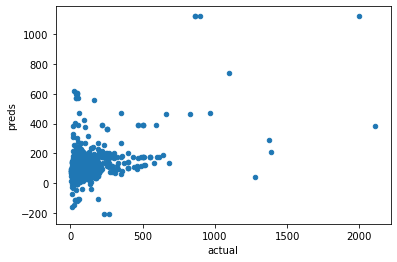

In [50]:
preds = ridge.predict(X_test)
df2 = pd.DataFrame({'preds':preds,'actual':y_test,'delta':y_test-preds})
df2.plot(y='preds',x='actual',kind='scatter')

<a name="timeseries"></a>

## Time Series Prediction

In [51]:
timeseriesdf = timeseries.to_frame()
timeseriesdf.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 203 entries, 2018-01-24 to 2018-08-29
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revenue  203 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [52]:
timeseriesdf

,revenue
order_purchase_timestamp(y-d),
2018-01-24,70.00
2018-01-26,634.40
2018-01-31,89.90
2018-02-02,104.49
2018-02-04,185.00
...,...
2018-08-25,1232.36
2018-08-26,1576.80
2018-08-27,689.56


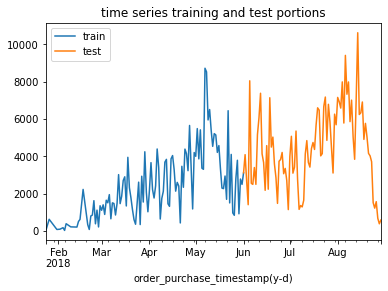

In [53]:
# split train and test 

train = timeseriesdf["2018-01-24":"2018-06-01"]
test = timeseriesdf["2018-06-01":]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.title('time series training and test portions');

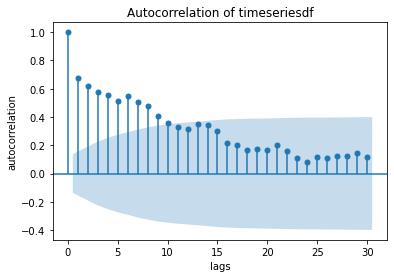

In [54]:
# autocorrelation

plot_acf(timeseriesdf, lags=30)  
plt.ylabel('autocorrelation')
plt.xlabel('lags')
plt.title('Autocorrelation of timeseriesdf');

This means that the spikes are statistically significant for lags up to 8 time periods (in this case, number of *days*)

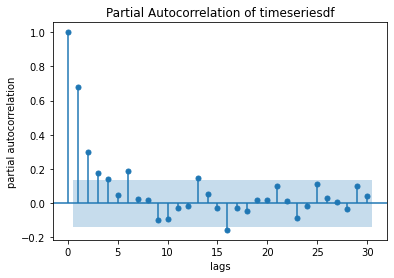

In [55]:
plot_pacf(timeseriesdf, lags=30)  
plt.xlabel('lags')
plt.ylabel('partial autocorrelation')
plt.title('Partial Autocorrelation of timeseriesdf');

In [56]:
#Apply min-max scaling

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

<a name="neuralnet"></a>

## Time Series - Neural Net

In [57]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

y_pred_fc = model.predict(X_test)


lstm_units = 6
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

y_pred_lstm = model.predict(X_test_t)

gru_units = 6 
K.clear_session()
model = Sequential()

model.add(GRU(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

y_pred_gru = model.predict(X_test_t)


Epoch 1/200
57/57 [==============================] - 0s 505us/step - loss: 0.1192
Epoch 2/200
57/57 [==============================] - 0s 546us/step - loss: 0.0578
Epoch 3/200
57/57 [==============================] - 0s 542us/step - loss: 0.0402
Epoch 4/200
57/57 [==============================] - 0s 477us/step - loss: 0.0362
Epoch 5/200
57/57 [==============================] - 0s 548us/step - loss: 0.0347
Epoch 6/200
57/57 [==============================] - 0s 490us/step - loss: 0.0336
Epoch 7/200
57/57 [==============================] - 0s 492us/step - loss: 0.0326
Epoch 8/200
57/57 [==============================] - 0s 597us/step - loss: 0.0320
Epoch 9/200
57/57 [==============================] - 0s 655us/step - loss: 0.0310
Epoch 10/200
57/57 [==============================] - 0s 625us/step - loss: 0.0306
Epoch 11/200
57/57 [==============================] - 0s 586us/step - loss: 0.0297
Epoch 12/200
57/57 [==============================] - 0s 570us/step - loss: 0.0293
Epoch 13/200


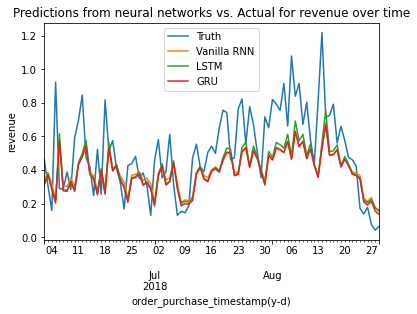

In [58]:
pd.DataFrame(
    {'Truth': sum(y_test.tolist(),[]),
     'Vanilla RNN': sum(y_pred_fc.tolist(),[]),
     'LSTM': sum(y_pred_lstm.tolist(),[]),
     'GRU':sum(y_pred_gru.tolist(),[])
     },index = test[1:].index).plot();

plt.title('Predictions from neural networks vs. Actual for revenue over time')
plt.ylabel('revenue');


<a name="prophet"></a>

## Time Series - FB prophet

In [59]:
prophetdf = prophetdf.reset_index()

prophetdf['order_purchase_timestamp'] = prophetdf['order_purchase_timestamp'].dt.round('D')

prophetdf = prophetdf.set_index(pd.to_datetime(prophetdf['order_purchase_timestamp'],unit='D'))

prophetdf.columns = ['ds', 'y']

In [60]:
train = prophetdf["2018-01-24":"2018-06-01"]
test = prophetdf["2018-06-01":]

train

,ds,y
order_purchase_timestamp,,
2018-01-25,2018-01-25,70.00
2018-01-27,2018-01-27,634.40
2018-02-01,2018-02-01,89.90
2018-02-02,2018-02-02,39.50
2018-02-03,2018-02-03,64.99
...,...,...
2018-06-01,2018-06-01,899.00
2018-06-01,2018-06-01,123.99
2018-06-01,2018-06-01,65.00


In [61]:
prophet = Prophet(interval_width=0.95, n_changepoints=20,yearly_seasonality=True,weekly_seasonality=True,changepoint_prior_scale=0.09)
prophet.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [62]:
forecast = prophet.predict(test)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-06-01,281.272364,-348.454588,680.295689,281.272364,281.272364,-108.114086,-108.114086,-108.114086,-25.388147,-25.388147,-25.388147,-82.725939,-82.725939,-82.725939,0.0,0.0,0.0,173.158278
1,2018-06-01,281.272364,-353.870606,676.924836,281.272364,281.272364,-108.114086,-108.114086,-108.114086,-25.388147,-25.388147,-25.388147,-82.725939,-82.725939,-82.725939,0.0,0.0,0.0,173.158278
2,2018-06-01,281.272364,-298.267649,640.389413,281.272364,281.272364,-108.114086,-108.114086,-108.114086,-25.388147,-25.388147,-25.388147,-82.725939,-82.725939,-82.725939,0.0,0.0,0.0,173.158278
3,2018-06-01,281.272364,-308.633202,687.027692,281.272364,281.272364,-108.114086,-108.114086,-108.114086,-25.388147,-25.388147,-25.388147,-82.725939,-82.725939,-82.725939,0.0,0.0,0.0,173.158278
4,2018-06-01,281.272364,-394.864415,652.260879,281.272364,281.272364,-108.114086,-108.114086,-108.114086,-25.388147,-25.388147,-25.388147,-82.725939,-82.725939,-82.725939,0.0,0.0,0.0,173.158278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2877,2018-08-29,386.151212,-174.061177,811.858520,386.150356,386.152172,-66.569788,-66.569788,-66.569788,-3.184466,-3.184466,-3.184466,-63.385322,-63.385322,-63.385322,0.0,0.0,0.0,319.581424
2878,2018-08-29,386.151212,-156.198750,865.275290,386.150356,386.152172,-66.569788,-66.569788,-66.569788,-3.184466,-3.184466,-3.184466,-63.385322,-63.385322,-63.385322,0.0,0.0,0.0,319.581424
2879,2018-08-29,386.151212,-164.354267,790.132054,386.150356,386.152172,-66.569788,-66.569788,-66.569788,-3.184466,-3.184466,-3.184466,-63.385322,-63.385322,-63.385322,0.0,0.0,0.0,319.581424
2880,2018-08-29,386.151212,-183.623755,829.343876,386.150356,386.152172,-66.569788,-66.569788,-66.569788,-3.184466,-3.184466,-3.184466,-63.385322,-63.385322,-63.385322,0.0,0.0,0.0,319.581424


In [63]:
print("RMSE: ", sqrt(mean_squared_error(test['y'], forecast['yhat'])))

RMSE:  303.24157238305145


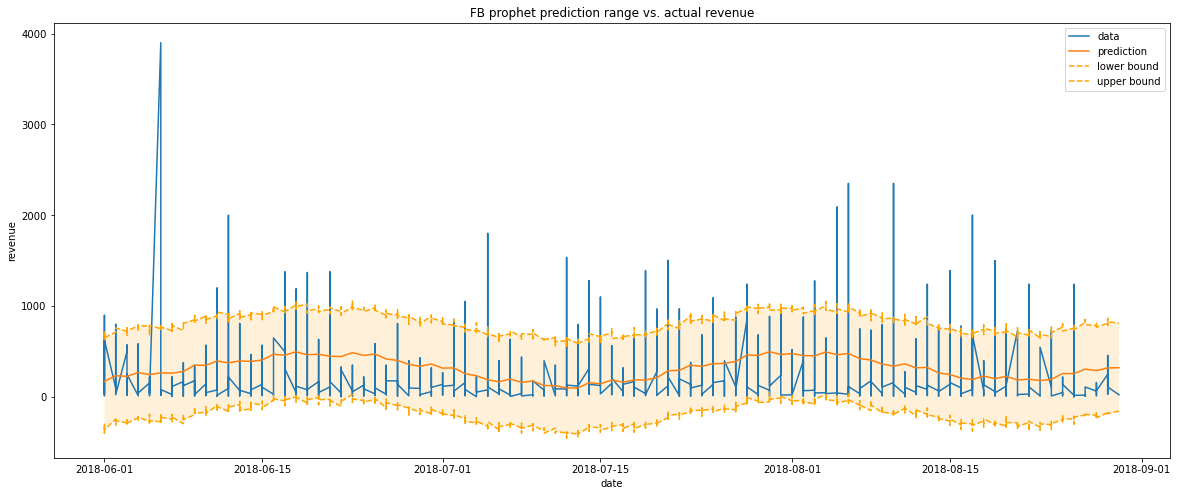

In [64]:
plt.figure(figsize=(20,8))
plt.plot(test['ds'], test['y'].values, label="data")
plt.plot(test['ds'], forecast['yhat'].values, label="prediction")
plt.plot(test['ds'], forecast['yhat_lower'].values, c="orange", label="lower bound", linestyle='--')
plt.plot(test['ds'], forecast['yhat_upper'].values, c="orange", label="upper bound", linestyle='--')
ax = plt.gca()
ax.fill_between(test['ds'],  forecast['yhat_lower'], forecast['yhat_upper'], facecolor='orange', alpha=0.15, interpolate=True)
plt.legend()
plt.title('FB prophet prediction range vs. actual revenue')
plt.xlabel('date')
plt.ylabel('revenue');